In [ ]:
67l6y6y# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# method to get unique words and sentence count in a list of text
def get_sentence_word_count(text_list):
    sent_count = 0 # keep track of the total number of sentences and
    word_count = 0 # unique words across all texts in the list.
    vocab = {} # keep track of the frequency of each word across all texts in the list.
    for text in text_list: # converts it to lowercase and
        sentences=sent_tokenize(str(text).lower()) # uses the sent_tokenize() function from NLTK to split it into sentences.
        sent_count = sent_count + len(sentences) # Increments the sent_count variable by the number of sentences in the current text.
        for sentence in sentences:
            words=word_tokenize(sentence) # word_tokenize() function from NLTK to split it into words.
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1 # updates the frequency count of the word in the vocab dictionary.
                else:
                    vocab[word] =1 # If the word is not already present in vocab it is added to the dictionary with a frequency count of 1.
    word_count = len(vocab.keys()) #the function sets the word_count variable to the number of unique words in the vocab dictionary
    return sent_count,word_count # and returns a tuple containing the sent_count and word_count values.

In [ ]:
clinical_text_df = pd.read_csv("clinical_records.csv")
print(clinical_text_df.columns)
clinical_text_df.head(5)


Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()] # removes any rows in the data frame where the 'transcription'column contains missing values.
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist()) # counts the total number of sentences and unique words in the list of transcriptions.
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty']) # groups the data frame by the 'medical_specialty' column.
i = 1
print('******Original Categories******')
for catName,dataCategory in data_categories: # prints the category and number of rows in that category.
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

Number of sentences in transcriptions column: 140208
Number of unique words in transcriptions column: 35805
******Original Categories******
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthopedic : 355
Cat:29  Pain M

In [ ]:
# removed the categories with less than 50 samples
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty']) # filtered data is then grouped again by medical specialty.
i=1
print('******Reduced Categories******')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

******Reduced Categories******
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156


In [ ]:
print('*******Reduced Categories Transcription example*******')
i=1
for catName,dataCategory in final_data_categories:
  print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)))
  dataList=dataCategory['transcription'].tolist()
  print('***********')
  print('Sample Transcription:'+str(dataList[10]))
  print('***********')
  i=i+1


*******Reduced Categories Transcription example*******
Cat:1  Cardiovascular / Pulmonary : 371
***********
Sample Transcription:PREOPERATIVE DIAGNOSIS: , Need for intravenous access.,POSTOPERATIVE DIAGNOSIS: , Need for intravenous access.,PROCEDURE PERFORMED:  ,Insertion of a right femoral triple lumen catheter.,ANESTHESIA: , Includes 4 cc of 1% lidocaine locally.,ESTIMATED BLOOD LOSS: , Minimum.,INDICATIONS:,  The patient is an 86-year-old Caucasian female who presented to ABCD General Hospital secondary to drainage of an old percutaneous endoscopic gastrostomy site.  The patient is also ventilator-dependent, respiratory failure with tracheostomy in place and dependent on parenteral nutrition secondary to dysphagia and also has history of protein-calorie malnutrition and the patient needs to receive total parenteral nutrition and therefore needs central venous access.,PROCEDURE:,  The patient's legal guardian was talked to.  All questions were answered and consent was obtained.  The p

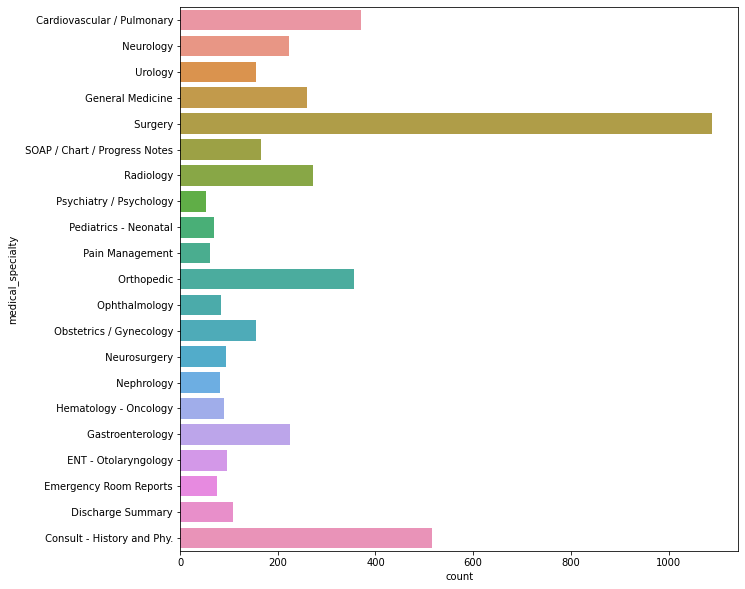

In [ ]:
plt.figure(figsize=(10,10)) # sets the size of the plot to 10 by 10 inches.
sns.countplot(y='medical_specialty', data = filtered_data_categories ) # to visualize the distribution of the medical specialties. The y parameter specifies the column to count(medical_specialty).
plt.show()

In [ ]:
# interested only in the 'transcription' and 'medical_specialty' columns in the dataset
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index) # it drops any rows from data where the 'transcription' value is missing (NaN).
data.shape # will show the number of rows and columns.

(4597, 2)

In [ ]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n') # The transcription content is accessed using the iloc method and specifying the row index number.
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n') # The first print statement displays the transcription at index 5
print('Sample Transcription 3:'+data.iloc[1000]['transcription']) # and so on.

Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, I

In [ ]:
# some methods for cleaning the data
def clean_text(text ):
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes all punctuation marks from the text
    text1 = ''.join([w for w in text if not w.isdigit()]) # remove digits from the text and replace them with a space character.
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') # used to create a pattern object that can be used for matching within text.
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) #replace REPLACE_BY_SPACE_RE symbols by space in text
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() # instance of the WordNetLemmatizer class from nltk.
    sentences=sent_tokenize(text) # tokenizes the input text into sentences.

    intial_sentences= sentences[0:1] # extracting the first
    final_sentences = sentences[len(sentences)-2: len(sentences)-1] # and last sentences.

    for sentence in intial_sentences:
        words=word_tokenize(sentence) # tokenizes them into words.
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))# lemmatizes each word using WordNetLemmatizer.
    for sentence in final_sentences:
        words=word_tokenize(sentence) # # tokenizes them into words.
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word)) # lemmatizes each word using WordNetLemmatizer.
    return ' '.join(wordlist) # returns the lemmatized words as a single string where each word is separated by space.

In [ ]:
# lets clean the data
data['transcription'] = data['transcription'].apply(lemmatize_text) # applies the lemmatize_text fn which tokenizes the text into sentences, lemmatizes each word using WordNetLemmatizer, and returns a single string of lemmatized words. The lemmatized text replaces the original text in the transcription column.
data['transcription'] = data['transcription'].apply(clean_text) # applies the clean_text fn which removes all punctuation, digits, and certain special characters from the transcription text, lowercases it, and replaces certain special characters with a space. The cleaned text replaces the lemmatized text in the transcription column.

In [ ]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n') # The transcription content is accessed using the iloc method and specifying the row index number
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n') # The first print statement displays the transcription at index 5
print('Sample Transcription 3:'+data.iloc[1000]['transcription']) # and so on.

Sample Transcription 1:cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation  obgyn exam including cervical biopsy  and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix 

Sample Transcription 2:admitting diagnoses    this is scheduled for the week after discharge potentially by dr g  and the patient will discus the exact time later this week 

Sample Transcription 3:preoperative diagnoses   phimosis and adhesions  postoperative diagnoses   phimosis and adhesions  procedures performed   circumcision and release of ventral chordee  anesthesia   local mac  estimated blood loss   minimal  fluids   crystalloid  plan wa for removal of the dressing tomorrow 


In [ ]:
# feature extraction using TfidfVectorizer to generate tf-idf features
# tf–idf is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus
# It is often used as a weighting factor
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000) # The TfidfVectorizer converts a collection of raw text documents into a matrix of TF-IDF features.
# The input to the vectorizer is the 'transcription' column of the 'data' dataframe.
# The 'analyzer' parameter is set to 'word', which means that the vectorizer will treat each word as a feature.
# The 'stop_words' parameter is set to 'english', which means that common English stop words like 'a', 'an', 'the', etc. will be removed.
# The 'ngram_range' parameter is set to (1,3), which means that the vectorizer will generate features for unigrams, bigrams, and trigrams.
# The 'max_df' parameter is set to 0.75, which means that words occurring in more than 75% of the documents will be ignored.
# The 'use_idf' parameter is set to True, which means that inverse-document-frequency reweighting will be applied.
# The 'smoothing is applied to prevent very rare words from having too much importance in the final document vectors.
# The 'max_features' parameter is set to 1000, which means that only the top 1000 most frequent features will be used.
# The output of the vectorizer is a sparse matrix containing the TF-IDF features for each document in the collection.
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist()) # fit transform used to compute the TF-IDF matrix for the given input data.
feature_names = sorted(vectorizer.get_feature_names_out()) # The feature names are obtained using the 'get_feature_names()' method of the vectorizer, and then sorted alphabetically.
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admitted', 'admitting', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'anemia', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthesia wa', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bleeding', 'block', 'blood', 'blood loss', 'blood loss cc', 'blood loss minimal', '

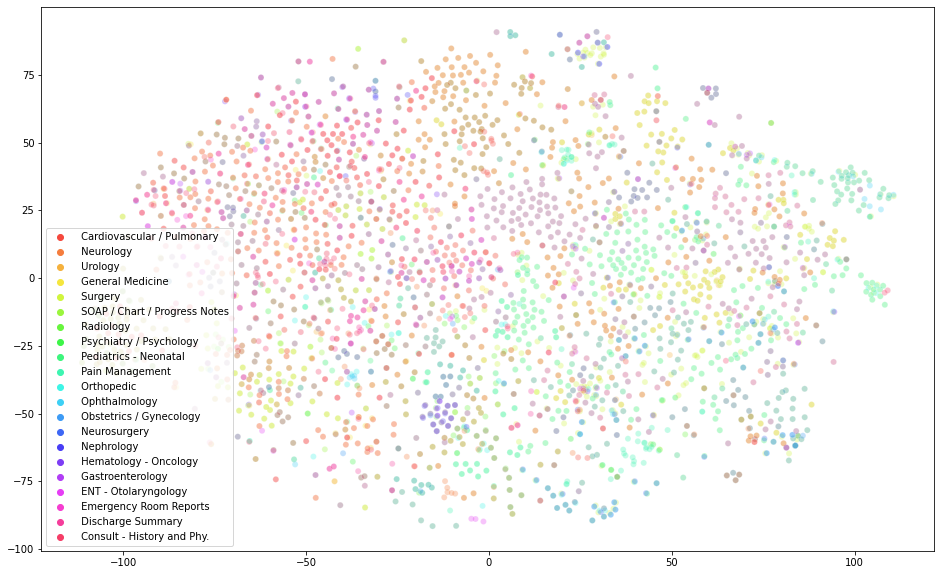

In [ ]:
# visualizing the tf-idf features
# T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization
#  It is a nonlinear dimensionality reduction technique .
# it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points
# and dissimilar objects are modeled by distant points with high probability.
import gc
gc.collect() # to perform garbage collection and free up memory resources.
tfIdfMatrix = tfIdfMat.toarray() # converts the sparse matrix tfIdfMat into a dense matrix tfIdfMatrix(a dense matrix representation of the data)
labels = data['medical_specialty'].tolist() # creates a list of the medical specialty labels for each sample in the data.
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
#  applies tSNE to the dense tf-idf matrix, reducing its dimensions to two.
# The n_components=2 argument specifies that we want to reduce the dimensions to 2.
# init='random' indicates that we want to use a random initialization of the embedding.
# The perplexity=40,is a hyperparameter that controls the balance between preserving local and global structure in the data.
palette = sns.hls_palette(21, l=.6, s=.9) # creates a color palette to use for the plot.
sns.scatterplot(    # to plot the t-SNE reduced data points in a two-dimensional space.
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
# x and y parameters specify the coordinates of the data points in the plot.
# hue specifies the variable used for coloring the data points (in this case, the medical specialty labels).
# palette specifies the color scheme used for the different labels.
# legend is set to "full" to display the legend for the plot."full" means that all the unique values in the hue variable will be displayed in the legend.
# alpha specifies the transparency level of the data points in the plot.
plt.show()

In [ ]:
# PCA to reduce dimensionality of features, while retaining most of the variance in the original dataset.
gc.collect() # to perform garbage collection and free up memory resources.
pca = PCA(n_components=0.95) # specifies that the number of principal components should be chosen such that it explains 95% of the variance in the data.
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray()) # new feature matrix with a reduced number of features (columns) but still contains the most important information from the original data.
labels = data['medical_specialty'].tolist() # contains the medical specialty of each transcription.
category_list = data.medical_specialty.unique() #  It contains all the unique medical specialties found in the dataset.
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1) # used to randomly split the dataset into training and testing sets.
# X:features or independent variables to be split
# y: the target or dependent variable to be split
# stratify: used for stratified sampling which enbsures that the distribution of classes in the training and testing sets are the same as in the original dataset
# random_state: used to ensure that the random split is reproducible

In [ ]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3447, 587)
Test_Set_Size:(1150, 587)


In [ ]:
# Logisitic Regression to learn on training data and predict on test data.
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
# fitting a Logistic Regression model to the training data and using the trained model to make predictions on the test data.
# penalty:Elastic Net regularization, which is a combination of L1 and L2 regularization.
# solver:Stochastic Average Gradient Descent (SAGA), which is a solver that can handle both L1 and L2 penalties.
# l1_ratio:ratio of L1 regularization to total regularization (L1 + L2).
y_test_pred= clf.predict(X_test) # using the trained model to make predictions on the test data.

In [ ]:
# visualizing the confusion matrix and the classsification results
labels = category_list
cm = confusion_matrix(y_test,y_test_pred,labels=category_list)

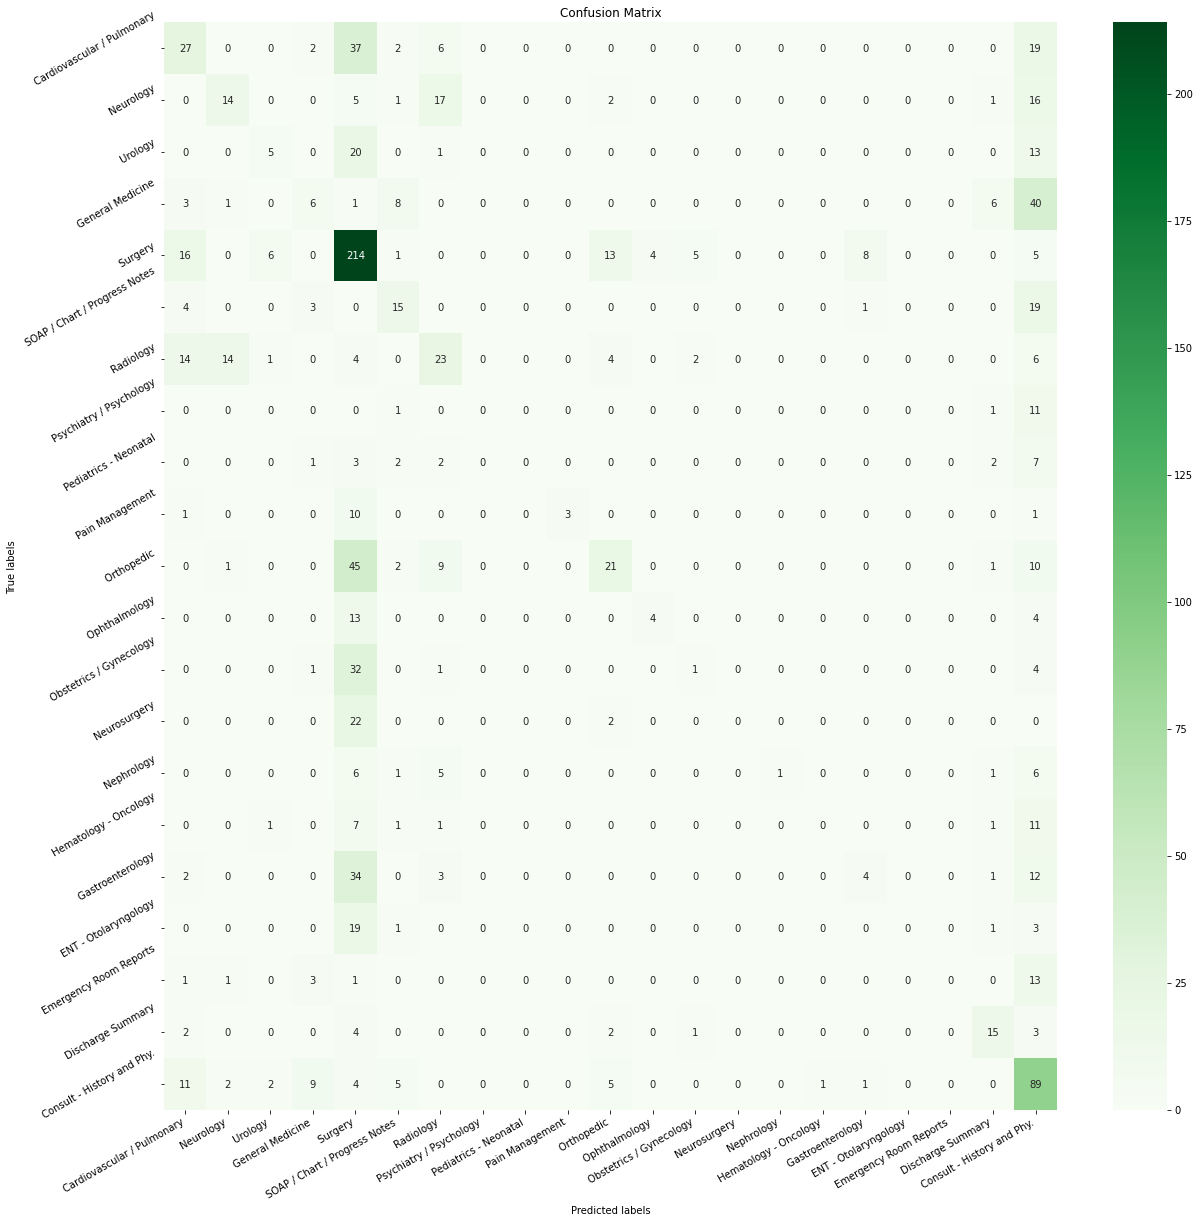

In [ ]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax=ax,fmt='g'); # creates a heatmap visualization of the confusion matrix.
#annot=True to displays the values in each cell of the heatmap.
# fmt specifies the format of the cell values to be general numeric format.
# cmap sets the color map of the heatmap to be green shades.

# labels, title and ticks
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [ ]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.33      0.29      0.31        93
                     Neurology       0.42      0.25      0.31        56
                       Urology       0.33      0.13      0.19        39
              General Medicine       0.24      0.09      0.13        65
                       Surgery       0.44      0.79      0.57       272
 SOAP / Chart / Progress Notes       0.38      0.36      0.37        42
                     Radiology       0.34      0.34      0.34        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       1.00      0.20      0.33        15
                    Orthopedic       0.43      0.24      0.30        89
                 Ophthalmology       0.50      0.19      0.28        21
       Obstetrics / Gynecology       0.11      0.03      0.04  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# The results are quite poor. The surgey category is kind of superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc.
# Similarly other categories like Emergency Room Reports, Discharge Summary, Notes also overlap with specialities. Hence i remove them to improve the results.
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
# applies a fn to strip any whitespace from the beginning and end of each value in the 'medical_specialty' column of the 'filtered_data_categories' dataframe.
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
# creates a boolean mask 'mask' where each element is True if the corresponding element in filtered_data_categories['medical_specialty'] is equal to the string 'Surgery'.
filtered_data_categories = filtered_data_categories[~mask]
# '~' negates the mask so that it selects all rows except those where the medical_specialty is 'Surgery'.
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
# final_data_categories is a grouped DataFrame that can be used to analyze the text data by medical specialty.
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]


'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''

mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]

mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
# checking if the value in each row of the 'medical_specialty' column is equal to 'Neurosurgery'. If it is, it replaces it with 'Neurology'.
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
# used to replace the values of a column 'medical_specialty' in 'filtered_data_categories'.
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'

i=1
print('******Reduced Categories******')
for catName,dataCategory in final_data_categories:   # prints the category and number of rows in that category.
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
data = filtered_data_categories[['transcription', 'medical_specialty']] # selecting two columns from filtered_data_categories
data = data.drop(data[data['transcription'].isna()].index) # drops any rows where the value in the 'transcription' column is missing (NaN).
data.shape

******Reduced Categories******
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 ENT - Otolaryngology : 96
Cat:3 Gastroenterology : 224
Cat:4 Hematology - Oncology : 90
Cat:5 Neurology : 317
Cat:6 Obstetrics / Gynecology : 155
Cat:7 Ophthalmology : 83
Cat:8 Orthopedic : 355
Cat:9 Pediatrics - Neonatal : 70
Cat:10 Psychiatry / Psychology : 53
Cat:11 Radiology : 273
Cat:12 Urology : 237


(2324, 2)

In [ ]:
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [ ]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation  obgyn exam including cervical biopsy  and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix 

Sample Transcription 2:preoperative diagnoses    it ha been discussed with his primary physician that the patient will likely need a nephrectomy 

Sample Transcription 3:preoperative diagnoses  there were no complication 


In [ ]:
# extracting the features
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abnormality', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'administration', 'admission', 'admitted', 'admitting', 'africanamerican', 'age', 'ago', 'airway', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'anterior cervical', 'anterior cervical discectomy', 'antibiotic', 'aortic', 'aortic stenosis', 'ap', 'apparent', 'appear', 'appendicitis', 'applied', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'assessment', 'associated', 'atelectasis', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'began', 'benefit', 'benign', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bleeding', 'block', 'blood', 'blo

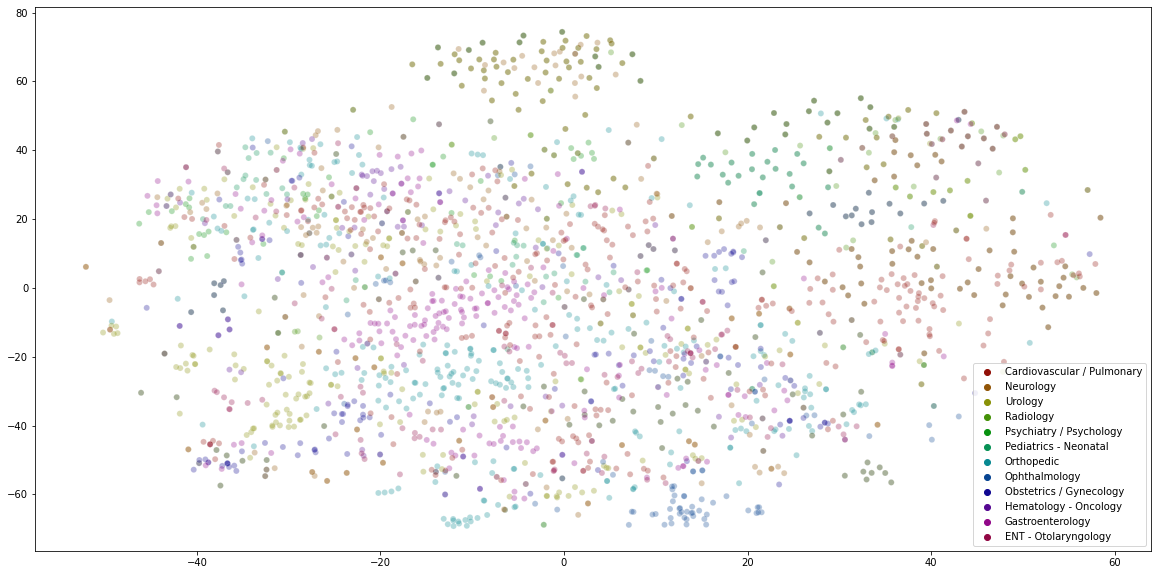

In [ ]:
# visualizing using the tsne plot
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.toarray()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 557)
Test_Set_Size:(581, 557)


In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

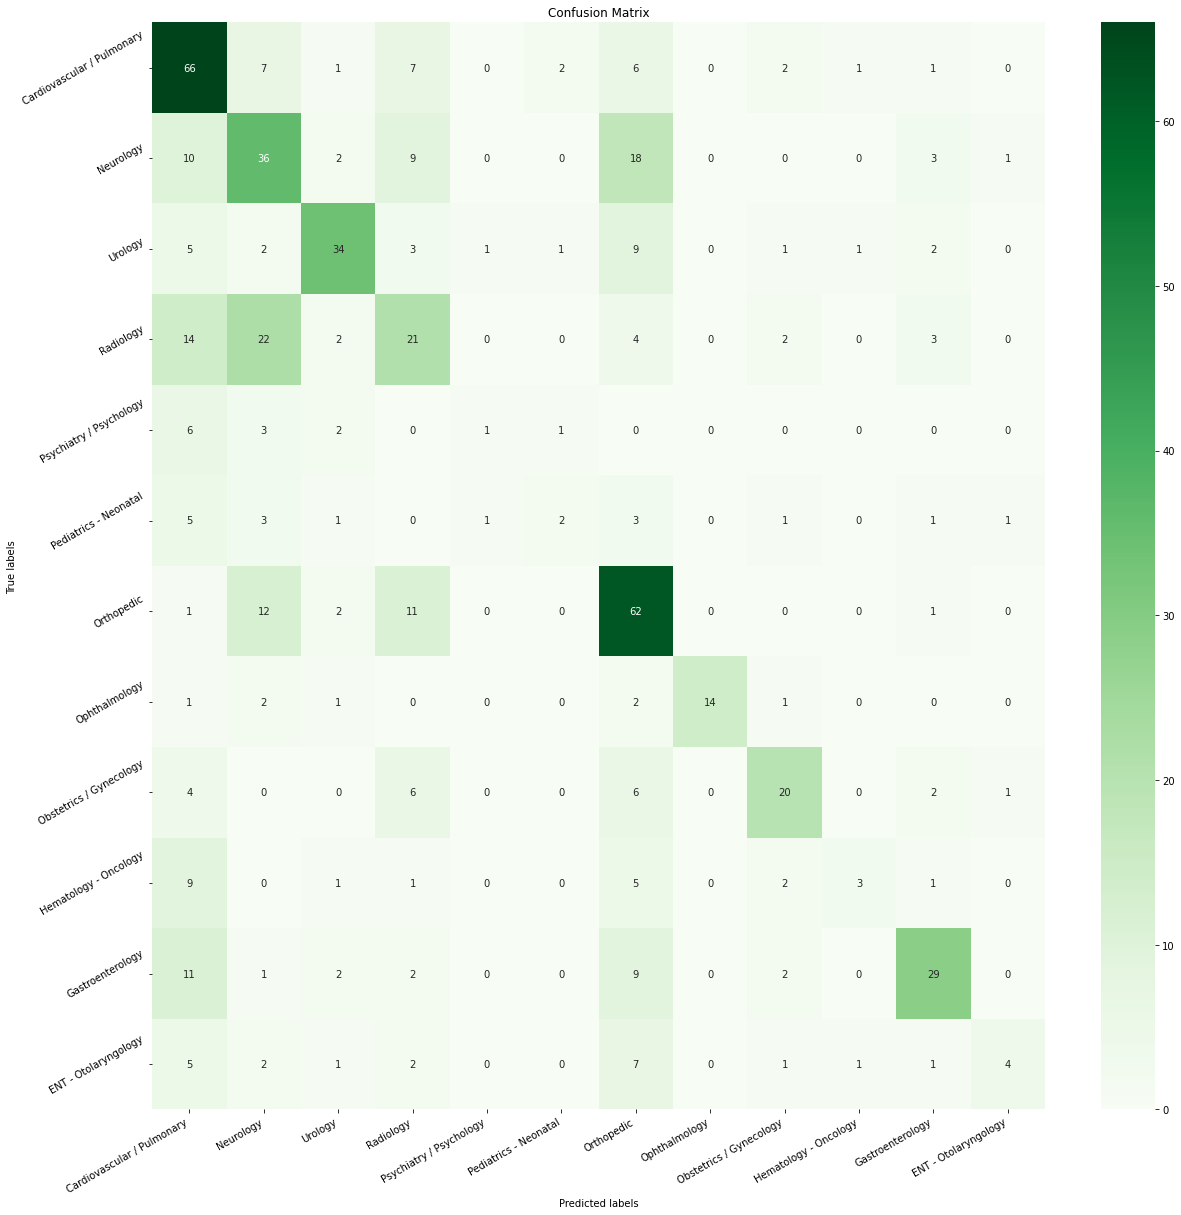

In [ ]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [ ]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.48      0.71      0.57        93
                 Neurology       0.40      0.46      0.43        79
                   Urology       0.69      0.58      0.63        59
                 Radiology       0.34      0.31      0.32        68
   Psychiatry / Psychology       0.33      0.08      0.12        13
     Pediatrics - Neonatal       0.33      0.11      0.17        18
                Orthopedic       0.47      0.70      0.56        89
             Ophthalmology       1.00      0.67      0.80        21
   Obstetrics / Gynecology       0.62      0.51      0.56        39
     Hematology - Oncology       0.50      0.14      0.21        22
          Gastroenterology       0.66      0.52      0.58        56
      ENT - Otolaryngology       0.57      0.17      0.26        24

                  accuracy                           0.50       581
                 macro avg       0.53      0.4

In [ ]:
# we use SMOTE(Synthetic Minority Over-sampling Technique ) to generate more sample for minority class to solve the data imbalance problem.
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1981, 557)
Test_Set_Size:(661, 557)


In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

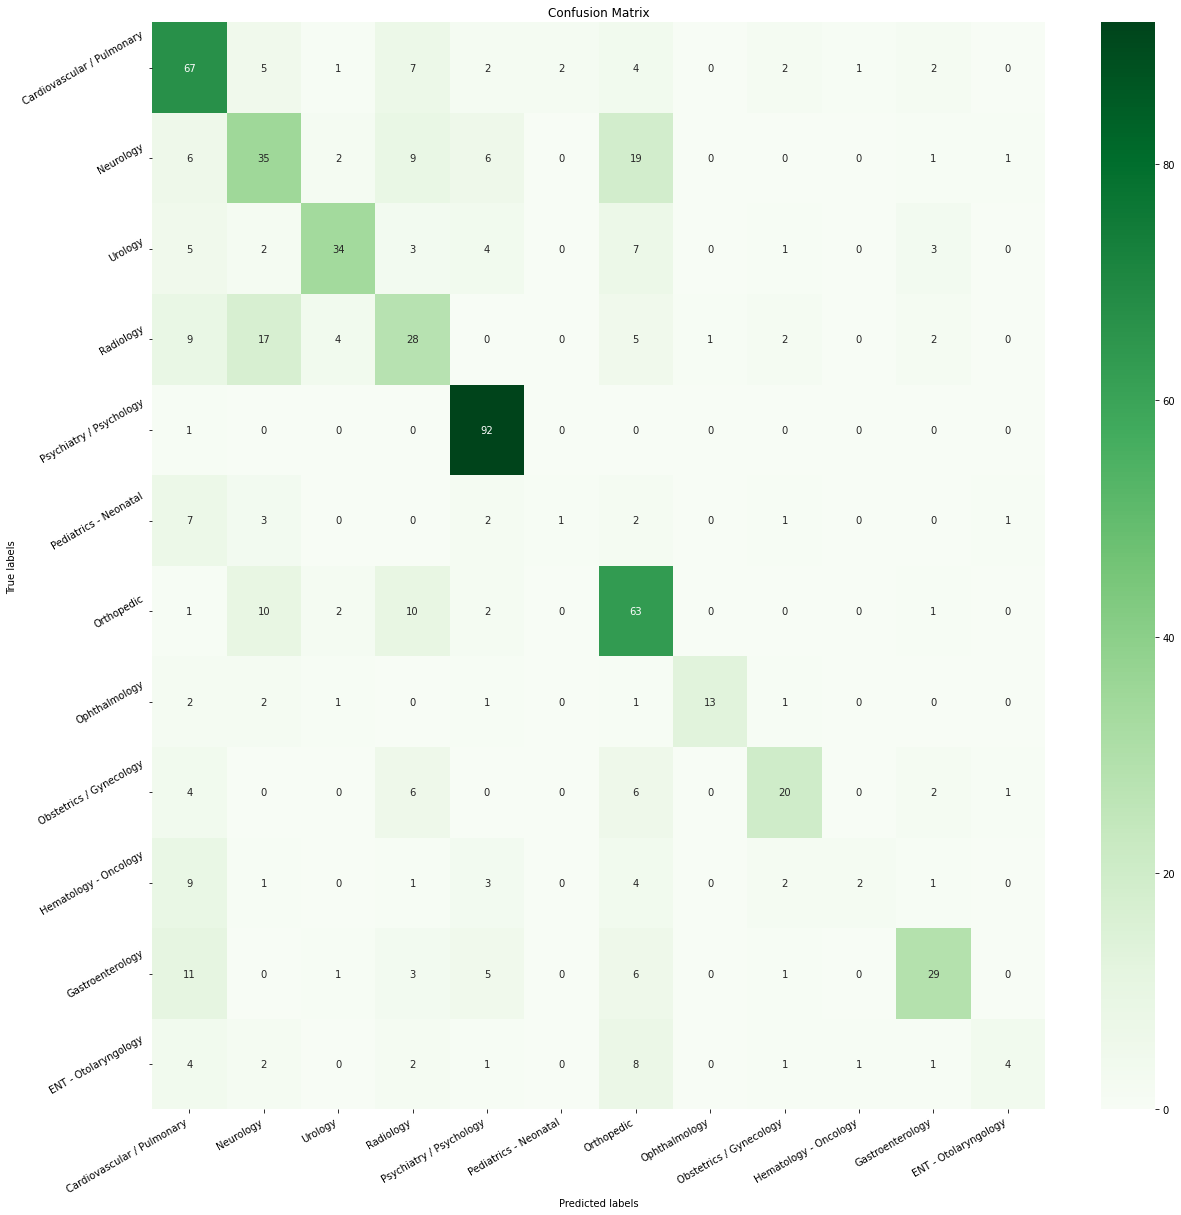

In [ ]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [ ]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.53      0.72      0.61        93
                 Neurology       0.45      0.44      0.45        79
                   Urology       0.76      0.58      0.65        59
                 Radiology       0.41      0.41      0.41        68
   Psychiatry / Psychology       0.78      0.99      0.87        93
     Pediatrics - Neonatal       0.33      0.06      0.10        17
                Orthopedic       0.50      0.71      0.59        89
             Ophthalmology       0.93      0.62      0.74        21
   Obstetrics / Gynecology       0.65      0.51      0.57        39
     Hematology - Oncology       0.50      0.09      0.15        23
          Gastroenterology       0.69      0.52      0.59        56
      ENT - Otolaryngology       0.57      0.17      0.26        24

                  accuracy                           0.59       661
                 macro avg       0.59      0.4

In [ ]:
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
radiologyData = filtered_data_categories[mask]
print(radiologyData['transcription'].tolist()[1])

EXAM: , Two views of the soft tissues of the neck.,HISTORY:,  Patient has swelling of the left side of his neck.,TECHNIQUE:,  Frontal and lateral views of the soft tissues of the neck were evaluated. There were no soft tissues of the neck radiographs for comparison. However, there was an ultrasound of the neck performed on the same day.,FINDINGS: , Frontal and lateral views of the soft tissues of the neck were evaluated and reveal there is an asymmetry seen to the left-sided soft tissues of the patient's neck which appear somewhat enlarged when compared to patient's right side. However the trachea appears to be normal caliber and contour.  Lateral views show a patent airway. The adenoids and tonsils appear normal caliber without evidence of hypertrophy. Airway appears patent. Osseous structures appear grossly normal.,IMPRESSION:,1. Patent airway. No evidence of any soft tissue swelling involving the patient's adenoids/tonsils, epiglottis or aryepiglottic folds. No evidence of any preve

In [ ]:
mask = clinical_text_df['medical_specialty'] ==  ' Pediatrics - Neonatal'
pediaData = clinical_text_df[mask]
print(pediaData ['transcription'].tolist()[1])

SUBJECTIVE:,  Patient presents with Mom and Dad for her 5-year 3-month well-child check.  Family has not concerns stating patient has been doing well overall since last visit.  Taking in a well-balanced diet consisting of milk and dairy products, fruits, vegetables, proteins and grains with minimal junk food and snack food.  No behavioral concerns.  Gets along well with peers as well as adults.  Is excited to start kindergarten this upcoming school year.  Does attend daycare.  Normal voiding and stooling pattern.  No concerns with hearing or vision.  Sees the dentist regularly.  Growth and development:  Denver II normal passing all developmental milestones per age in areas of fine motor, gross motor, personal and social interaction and speech and language development.  See Denver II form in the chart.,ALLERGIES:,  None.,MEDICATIONS: , None.,FAMILY SOCIAL HISTORY:,  Unchanged since last checkup.  Lives at home with mother, father and sibling.  No smoking in the home.,REVIEW OF SYSTEMS:,

In [ ]:
mask = clinical_text_df['medical_specialty'] ==  ' Hematology - Oncology'
oncoData = clinical_text_df[mask]
print(oncoData ['transcription'].tolist()[1])

CHIEF COMPLAINT:,  Essential thrombocytosis.,HISTORY OF PRESENT ILLNESS: , This is an extremely pleasant 64-year-old gentleman who I am following for essential thrombocytosis.  He was first diagnosed when he first saw a hematologist on 07/09/07.  At that time, his platelet count was 1,240,000.  He was initially started on Hydrea 1000 mg q.d.  On 07/11/07, he underwent a bone marrow biopsy, which showed essential thrombocytosis.  He was positive for the JAK-2 mutation.  On 11/06/07, his platelets were noted to be 766,000.  His current Hydrea dose is now 1500 mg on Mondays and Fridays and 1000 mg on all other days.  He moved to ABCD in December 2009 in an attempt to improve his wife's rheumatoid arthritis.,Overall, he is doing well.  He has a good energy level, and his ECOG performance status is 0.  He denies any fevers, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Hydrea 1500 mg on Mondays and Fridays